##10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

- 데이터 세트의 속성
  - train_id: 데이터 id
  - name: 제품명
  - item_condition_id: 판매자가 제공한느 제품 상태
  - category_name: 카테고리 명
  - brand_name: 브랜드 이름
  - price: 제품 가겨그 예측을 위한 타깃 속성 (예측해야 하는 타깃 값)
  - shipping: 배송비 무료 여부, 1이면 무료, 0이면 유료
  - item_description: 제품에 대한 설명
- 회귀로 피처를 학습한 뒤 price를 예측하는 문제

###데이터 전처리

In [3]:
# 필요한 라이브러리와 함께 데이터셋을 로딩 후 간략히 살펴보기
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mercari_dataset/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


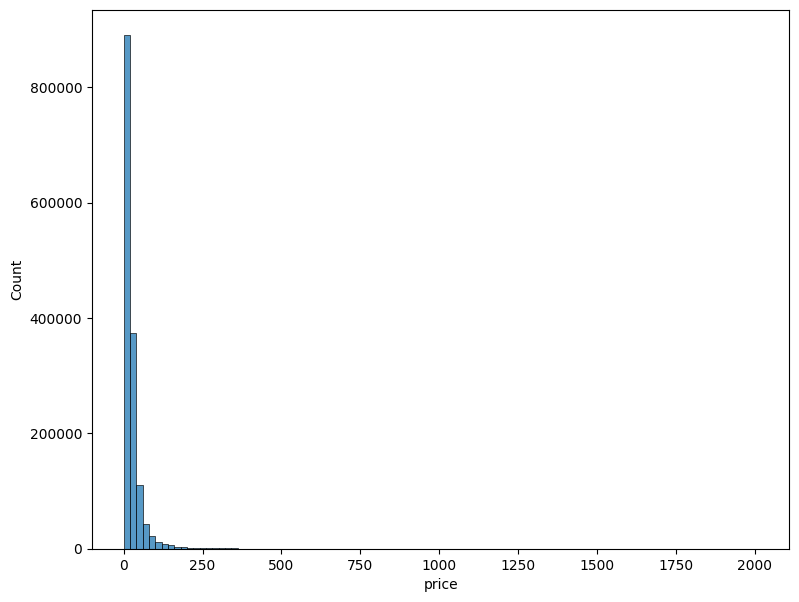

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(9, 7))
sns.histplot(y_train_df, bins=100)
plt.show()

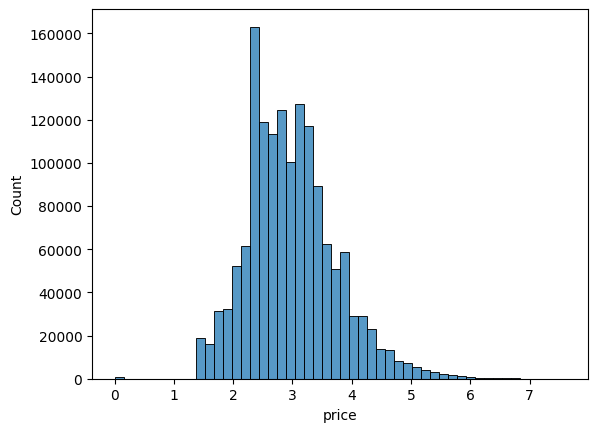

In [6]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [7]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [8]:
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts()) # 배송비 유무를 나타냄, 값이 비교적 균일
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts()) # 판매자가 제공하는 제품 상태 ->1,2,3 값이 주를 이룸

Shipping 값 유형: 
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [9]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

In [10]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성. 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에서 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
  zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형: \n', mercari_df['cat_jung'].nunique())
print('소분류 유형: \n', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 유형: 
 114
소분류 유형: 
 871


In [11]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null값 건수 확인, 모두 0이 나와야 합니다
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


###피처 인코딩과 피처 벡터화
- 데이터 세트 내에는 문자열 칼럼이 많음
  - 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 백터화로 변환할 칼럼을 선별해야함
- 피처를 어떤 방식으로 변환할지 검토 -> 일괄적으로 전체 속성의 변환 작업을 적용
- 피처 벡터화 방식
  - 짧은 텍스트: Count 기반의 벡터화
  - 긴 텍스트: TD-IDF기반의 벡터화
- 피처 인코딩 방식: 원핫 인코딩
- 모델링
  - 선형 회귀 모델 + 회귀 트리 모델

In [13]:
# brand_name 칼럼 검수
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- 명료한 문자열 형태
- 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환 수행

In [15]:
# name 칼럼 검수
print('name의 종류 개수', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 개수 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- 종류가 굉장히 많은 것을 확인 가능
- 유형이 매우 많고, 적은 단어 위주의 텍스트 형태 -> Count 기반의 피처 벡터화 적용

- Category_name
  - 이미 이전 전처리에서 대, 중, 소 분류 수행
  - 원핫인코딩만 적용 예정
- Shipping
  - 배송비 무료 여부(이진 변수)
  - 원핫 인코딩 적용
- item_condition_id
  - 상품 상태로, 1~5까지의 5개 유형의 값을 가짐
  - 웟핫 인코딩 적용

In [16]:
# item_description 칼럼 검수
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열이 굉장히 큼 -> TF-IDF 로 변환

In [17]:
# 주요 칼럼 인코딩 및 피처 벡터화 변환
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- fit_transform()을 통해 반환되는 데이터는 희소 행렬 형태
- 인코딩 대상 칼럼도 희소행렬 형태로 인코딩을 적용하여 함께 결합해야 함
  - LabelBinarizer 클래스 사용 : 희소 행렬 형태의 원-핫 인코딩 변환을 지원함

In [18]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
label_binarizer = LabelBinarizer(sparse_output=True)
X_brand = label_binarizer.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_shipping.fit_transform(mercari_df['cat_so'])

In [19]:
# 변환이 잘 되었는지 데이터 세트의 타입 및 shape 확인
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환덴 데이터 세트: CSR 형태로 변환된 csr_matrix 타입


In [20]:
# 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합하기
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


127

###릿지 회귀 모델 구축 및 평가
- 수행에 필요한 로직은 함수화하여 수행
  - 평가로직 함수화
     - 평가 지표: RMSLE -> RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식

In [21]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, y_pred):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(y_pred)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

- 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직도 별도 함수로 생성

In [22]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- Ridg를 이용한 회귀 예측 수행

In [23]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Description을  제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을  제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680432471796771


###LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
- LightGBM을 이용해 회귀를 수행한 뒤, 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값을 평가

In [ ]:
# LightGBM으로 회귀 예측
# from lightgbm import LGBMRegressor

# sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                     # X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156,verbose=-1)
# lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list=sparse_matrix_list)
# print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

- Ridge보다 예측 성능이 더 나아진 것을 확인 가능
- 이후 이 둘을 앙상블해 최종 예측 결괏값을 도출

(코드 소요시간이 오래걸려 주석처리 수행)

In [ ]:
# preds = lgbm_preds * 0.45 + linear_preds * 0.55
# print('LGBM과 Ridge를 앙상블한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

- 예측 성능을 더욱 개선할 수 있음